<a href="https://colab.research.google.com/github/AlexMontgomerie/deepLearning/blob/master/full_net_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%cd /content
#!rm -rf deepLearning
!git clone https://github.com/AlexMontgomerie/deepLearning
%cd deepLearning
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

/content
fatal: destination path 'deepLearning' already exists and is not an empty directory.
/content/deepLearning
RAM Free: 12.8 GB  | Proc size: 318.7 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
from common import *
!chmod +x setup.sh
!./setup.sh

In [11]:
import sys
import json
import os
import glob
import keras
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, UpSampling2D, concatenate, Subtract
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, STNHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
import matplotlib.pyplot as plt
from layers import BilinearInterpolation
from keras.layers import Layer, Lambda

random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

def run_sobel(image):
  tmp = tf.image.sobel_edges(image)[:,:,:,0]
  tmp = tf.multiply(tmp[:,:,:,0],tmp[:,:,:,1])
  return tf.expand_dims(tmp,3)
  #return tf.image.sobel_edges(image)[:,:,:,0]
      

def get_initial_weights(output_size):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((output_size, 6), dtype='float32')
    weights = [W, b.flatten()]
    return weights
  
def get_full_model(shape,denoise_init=None,stn_init=None):  
    #shape = (32, 32, 1)

    init_weights = keras.initializers.he_normal()
    # input 
    inputs = Input(shape)
    
    # denoise network
    depth1  = 16
    conv1_1 = Conv2D(depth1, 1, padding = 'same', kernel_initializer = 'he_normal', name='denoise_in')(inputs)

    # convolution layers
    conv1_2  = Conv2D(depth1, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_2' )(conv1_1)
    conv1_3  = Conv2D(depth1, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_3' )(conv1_1)
    conv1_5  = Conv2D(depth1, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_5' )(conv1_1)
    conv1_7  = Conv2D(depth1, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_7' )(conv1_1)
    conv1_9  = Conv2D(depth1, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_9' )(conv1_1)
    conv1_11 = Conv2D(depth1, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_11')(conv1_1)

    # network
    net1 = Subtract()([conv1_1, conv1_2])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_3])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_5])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_7])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_9])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_11])
    net1 = BatchNormalization()(net1)  

    # convolution layers
    depth2 = 16
    #conv2_1  = Conv2D(depth2, 1, padding = 'same', kernel_initializer = 'he_normal')(net1)
    conv2_2  = Conv2D(depth2, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_2' )(net1)
    conv2_3  = Conv2D(depth2, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_3' )(net1)
    conv2_5  = Conv2D(depth2, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_5' )(net1)
    conv2_7  = Conv2D(depth2, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_7' )(net1)
    conv2_9  = Conv2D(depth2, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_9' )(net1)
    conv2_11 = Conv2D(depth2, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_11')(net1)

    # network
    net2 = Subtract()([net1, conv2_2])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([net1, conv2_3])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([net1, conv2_5])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([net1, conv2_7])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([net1, conv2_9])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([net1, conv2_11])
    net2 = BatchNormalization()(net2)  

    # convolution layers
    depth3 = 16
    #conv3_1  = Conv2D(depth3, 1, padding = 'same', kernel_initializer = 'he_normal')(net1)
    conv3_2  = Conv2D(depth3, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_2' )(net2)
    conv3_3  = Conv2D(depth3, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_3' )(net2)
    conv3_5  = Conv2D(depth3, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_5' )(net2)
    conv3_7  = Conv2D(depth3, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_7' )(net2)
    conv3_9  = Conv2D(depth3, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_9' )(net2)
    conv3_11 = Conv2D(depth3, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_11')(net2)

    # network
    net3 = Subtract()([net2, conv3_2])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([net2, conv3_3])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([net2, conv3_5])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([net2, conv3_7])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([net2, conv3_9])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([net2, conv3_11])
    net3 = BatchNormalization()(net3)  

    net3 = Conv2D(1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_out' )(net3)
    
    # stn network    
    locnet = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer=init_weights, name='stn_1')(net3) # 32
    locnet = BatchNormalization(axis = -1)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    
    locnet = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=init_weights, name='stn_2')(locnet) # 32
    locnet = BatchNormalization(axis = -1)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    
    locnet = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=init_weights, name='stn_3')(locnet)  # 64
    locnet = BatchNormalization(axis = -1)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    
    locnet = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=init_weights, name='stn_4')(locnet)  # 128
    locnet = BatchNormalization(axis = -1)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    
    locnet = Flatten(name='stn_4.1')(locnet)
    locnet = Dense(256, name='stn_5')(locnet)
    locnet =  Dropout(0.25, name='stn_5.1')(locnet)
    locnet = Activation('softmax')(locnet)
    weights = get_initial_weights(256)
    locnet = Dense(6, weights=weights, name='stn_6')(locnet)
    stn    = BilinearInterpolation(shape[:-1])([net3, locnet])
      
    # sobel
    sobel = Lambda(run_sobel)(net3)
    
    # features in
    l2net = concatenate([ net3, stn , sobel ], axis = -1)
    
    # L2 Net    
    l2net = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(64, 3, padding='same', input_shape=shape, strides=2, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(64, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(128, 3, padding='same', input_shape=shape, strides=2, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(128, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(128, 8, padding='valid', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)

    l2net = Reshape((128,))(l2net)
  
    l2net = Model(inputs = inputs, outputs = l2net)
    
    if stn_init:
      l2net.load_weights(stn_init, by_name=True, skip_mismatch=True)
      
    if denoise_init:
      l2net.load_weights(denoise_init, by_name=True, skip_mismatch=True)
    
    descriptor_model = Sequential()
    descriptor_model.add(l2net)
    
    return descriptor_model

    
  
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')

#descriptor_model = get_full_model(shape)
descriptor_model = get_full_model(shape,'/content/denoise_model_ssim.weights.06-0.31.hdf5','/content/stn_model.weights.02-25.51.hdf5')

ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

  
def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)


loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer batch_normalization_78 due to mismatch in shape ((128,) vs (16,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer batch_normalization_84 due to mismatch in shape ((128,) vs (16,)).
  weight_values[i].shape))


In [7]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs))

### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    use_clean=False)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000, batch_size=500)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000, batch_size=500)

Using noisy patches
100%|██████████| 116/116 [00:33<00:00,  2.27it/s]


100%|██████████| 100000/100000 [00:01<00:00, 66038.81it/s]


Using noisy patches
100%|██████████| 116/116 [00:19<00:00,  5.87it/s]


100%|██████████| 10000/10000 [00:00<00:00, 65550.34it/s]


In [12]:
# callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 3, mode= 'auto'),
    keras.callbacks.ModelCheckpoint('data/descriptor_model.weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
]

descriptor_history = descriptor_model_trip.fit_generator(generator=training_generator, epochs=50, callbacks=callbacks,
                                              verbose=1, validation_data=val_generator)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
199/200 [============================>.] - ETA: 1s - loss: 0.4474

100%|██████████| 100000/100000 [00:02<00:00, 36325.63it/s]


200/200 [==============================] - 209s 1s/step - loss: 0.4469 - val_loss: 0.4942

Epoch 00001: val_loss improved from inf to 0.49420, saving model to data/descriptor_model.weights.01-0.49.hdf5


100%|██████████| 10000/10000 [00:00<00:00, 40305.24it/s]


Epoch 2/50
199/200 [============================>.] - ETA: 0s - loss: 0.2831

100%|██████████| 100000/100000 [00:02<00:00, 36964.21it/s]


200/200 [==============================] - 197s 986ms/step - loss: 0.2833 - val_loss: 0.3610

Epoch 00002: val_loss improved from 0.49420 to 0.36095, saving model to data/descriptor_model.weights.02-0.36.hdf5
Epoch 3/50
  1/200 [..............................] - ETA: 3:13 - loss: 0.2802

100%|██████████| 10000/10000 [00:00<00:00, 39141.96it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.2273

100%|██████████| 100000/100000 [00:02<00:00, 36517.62it/s]


200/200 [==============================] - 198s 992ms/step - loss: 0.2272 - val_loss: 0.2757

Epoch 00003: val_loss improved from 0.36095 to 0.27572, saving model to data/descriptor_model.weights.03-0.28.hdf5
Epoch 4/50
  1/200 [..............................] - ETA: 3:11 - loss: 0.1860

100%|██████████| 10000/10000 [00:00<00:00, 37999.28it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1994

100%|██████████| 100000/100000 [00:02<00:00, 36897.38it/s]


200/200 [==============================] - 197s 985ms/step - loss: 0.1995 - val_loss: 0.2276

Epoch 00004: val_loss improved from 0.27572 to 0.22759, saving model to data/descriptor_model.weights.04-0.23.hdf5
Epoch 5/50
  1/200 [..............................] - ETA: 3:13 - loss: 0.2013

100%|██████████| 10000/10000 [00:00<00:00, 37168.09it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1873

100%|██████████| 100000/100000 [00:03<00:00, 29968.96it/s]


200/200 [==============================] - 198s 990ms/step - loss: 0.1870 - val_loss: 0.2161

Epoch 00005: val_loss improved from 0.22759 to 0.21609, saving model to data/descriptor_model.weights.05-0.22.hdf5
Epoch 6/50
  1/200 [..............................] - ETA: 3:12 - loss: 0.1440

100%|██████████| 10000/10000 [00:00<00:00, 37210.56it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1775

100%|██████████| 100000/100000 [00:02<00:00, 36683.51it/s]


200/200 [==============================] - 198s 988ms/step - loss: 0.1774 - val_loss: 0.2119

Epoch 00006: val_loss improved from 0.21609 to 0.21192, saving model to data/descriptor_model.weights.06-0.21.hdf5
Epoch 7/50
  1/200 [..............................] - ETA: 3:14 - loss: 0.2052

100%|██████████| 10000/10000 [00:00<00:00, 39285.20it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1728

100%|██████████| 100000/100000 [00:02<00:00, 38019.02it/s]


200/200 [==============================] - 198s 989ms/step - loss: 0.1726 - val_loss: 0.1967

Epoch 00007: val_loss improved from 0.21192 to 0.19667, saving model to data/descriptor_model.weights.07-0.20.hdf5
Epoch 8/50
  1/200 [..............................] - ETA: 3:12 - loss: 0.1561

100%|██████████| 10000/10000 [00:00<00:00, 37906.46it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1624

100%|██████████| 100000/100000 [00:02<00:00, 36129.76it/s]


200/200 [==============================] - 198s 992ms/step - loss: 0.1626 - val_loss: 0.1962

Epoch 00008: val_loss improved from 0.19667 to 0.19616, saving model to data/descriptor_model.weights.08-0.20.hdf5
Epoch 9/50
  1/200 [..............................] - ETA: 3:11 - loss: 0.2145

100%|██████████| 10000/10000 [00:00<00:00, 37407.23it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1596

100%|██████████| 100000/100000 [00:02<00:00, 37298.70it/s]


200/200 [==============================] - 198s 989ms/step - loss: 0.1596 - val_loss: 0.1985

Epoch 00009: val_loss did not improve from 0.19616
Epoch 10/50
  2/200 [..............................] - ETA: 3:14 - loss: 0.1724

100%|██████████| 10000/10000 [00:00<00:00, 39500.75it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1566

100%|██████████| 100000/100000 [00:03<00:00, 30072.47it/s]


200/200 [==============================] - 198s 991ms/step - loss: 0.1566 - val_loss: 0.1949

Epoch 00010: val_loss improved from 0.19616 to 0.19492, saving model to data/descriptor_model.weights.10-0.19.hdf5
Epoch 11/50
  1/200 [..............................] - ETA: 3:11 - loss: 0.1569

100%|██████████| 10000/10000 [00:00<00:00, 34736.93it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1509

100%|██████████| 100000/100000 [00:02<00:00, 37786.29it/s]


200/200 [==============================] - 198s 989ms/step - loss: 0.1508 - val_loss: 0.1962

Epoch 00011: val_loss did not improve from 0.19492
Epoch 12/50
  2/200 [..............................] - ETA: 3:12 - loss: 0.1393

100%|██████████| 10000/10000 [00:00<00:00, 39024.26it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1466

100%|██████████| 100000/100000 [00:02<00:00, 37520.83it/s]


200/200 [==============================] - 198s 989ms/step - loss: 0.1467 - val_loss: 0.1903

Epoch 00012: val_loss improved from 0.19492 to 0.19030, saving model to data/descriptor_model.weights.12-0.19.hdf5
Epoch 13/50
  1/200 [..............................] - ETA: 3:12 - loss: 0.1248

100%|██████████| 10000/10000 [00:00<00:00, 36346.64it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1434

100%|██████████| 100000/100000 [00:02<00:00, 37022.88it/s]


200/200 [==============================] - 198s 990ms/step - loss: 0.1434 - val_loss: 0.1772

Epoch 00013: val_loss improved from 0.19030 to 0.17717, saving model to data/descriptor_model.weights.13-0.18.hdf5
Epoch 14/50
  1/200 [..............................] - ETA: 3:16 - loss: 0.1343

100%|██████████| 10000/10000 [00:00<00:00, 39234.71it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1445

100%|██████████| 100000/100000 [00:02<00:00, 36686.53it/s]


200/200 [==============================] - 197s 985ms/step - loss: 0.1443 - val_loss: 0.1783

Epoch 00014: val_loss did not improve from 0.17717
Epoch 15/50
  2/200 [..............................] - ETA: 3:12 - loss: 0.1413

100%|██████████| 10000/10000 [00:00<00:00, 38039.19it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1376

100%|██████████| 100000/100000 [00:03<00:00, 29802.07it/s]


200/200 [==============================] - 197s 985ms/step - loss: 0.1377 - val_loss: 0.1915

Epoch 00015: val_loss did not improve from 0.17717
Epoch 16/50
  2/200 [..............................] - ETA: 3:10 - loss: 0.1135

100%|██████████| 10000/10000 [00:00<00:00, 37688.80it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1390

100%|██████████| 100000/100000 [00:02<00:00, 36253.56it/s]


200/200 [==============================] - 197s 987ms/step - loss: 0.1390 - val_loss: 0.1850

Epoch 00016: val_loss did not improve from 0.17717
Epoch 17/50
  2/200 [..............................] - ETA: 3:13 - loss: 0.1497

100%|██████████| 10000/10000 [00:00<00:00, 37317.93it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1355

100%|██████████| 100000/100000 [00:02<00:00, 36159.65it/s]


200/200 [==============================] - 198s 989ms/step - loss: 0.1356 - val_loss: 0.1760

Epoch 00017: val_loss improved from 0.17717 to 0.17597, saving model to data/descriptor_model.weights.17-0.18.hdf5
Epoch 18/50
  1/200 [..............................] - ETA: 3:11 - loss: 0.1665

100%|██████████| 10000/10000 [00:00<00:00, 38168.73it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1355

100%|██████████| 100000/100000 [00:02<00:00, 35857.71it/s]


200/200 [==============================] - 198s 991ms/step - loss: 0.1355 - val_loss: 0.1644

Epoch 00018: val_loss improved from 0.17597 to 0.16444, saving model to data/descriptor_model.weights.18-0.16.hdf5
Epoch 19/50
  1/200 [..............................] - ETA: 3:15 - loss: 0.1208

100%|██████████| 10000/10000 [00:00<00:00, 38961.55it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1337

100%|██████████| 100000/100000 [00:02<00:00, 36663.24it/s]


200/200 [==============================] - 197s 985ms/step - loss: 0.1339 - val_loss: 0.1696

Epoch 00019: val_loss did not improve from 0.16444
Epoch 20/50
  2/200 [..............................] - ETA: 3:12 - loss: 0.1117

100%|██████████| 10000/10000 [00:00<00:00, 36682.32it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1309

100%|██████████| 100000/100000 [00:02<00:00, 34905.02it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.1308 - val_loss: 0.1756

Epoch 00020: val_loss did not improve from 0.16444
Epoch 21/50
  2/200 [..............................] - ETA: 3:12 - loss: 0.1162

100%|██████████| 10000/10000 [00:00<00:00, 35232.37it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1277

100%|██████████| 100000/100000 [00:02<00:00, 35929.70it/s]


200/200 [==============================] - 198s 988ms/step - loss: 0.1278 - val_loss: 0.1634

Epoch 00021: val_loss improved from 0.16444 to 0.16345, saving model to data/descriptor_model.weights.21-0.16.hdf5
Epoch 22/50
  1/200 [..............................] - ETA: 3:12 - loss: 0.1846

100%|██████████| 10000/10000 [00:00<00:00, 37325.24it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1266

100%|██████████| 100000/100000 [00:03<00:00, 29516.43it/s]


200/200 [==============================] - 198s 991ms/step - loss: 0.1267 - val_loss: 0.1564

Epoch 00022: val_loss improved from 0.16345 to 0.15637, saving model to data/descriptor_model.weights.22-0.16.hdf5
Epoch 23/50
  1/200 [..............................] - ETA: 3:14 - loss: 0.1354

100%|██████████| 10000/10000 [00:00<00:00, 38185.79it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1246

100%|██████████| 100000/100000 [00:02<00:00, 37882.92it/s]


200/200 [==============================] - 197s 986ms/step - loss: 0.1248 - val_loss: 0.1663

Epoch 00023: val_loss did not improve from 0.15637
Epoch 24/50
  2/200 [..............................] - ETA: 3:10 - loss: 0.1020

100%|██████████| 10000/10000 [00:00<00:00, 31390.87it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1240

100%|██████████| 100000/100000 [00:02<00:00, 37477.72it/s]


200/200 [==============================] - 198s 988ms/step - loss: 0.1240 - val_loss: 0.1675

Epoch 00024: val_loss did not improve from 0.15637
Epoch 25/50
  1/200 [..............................] - ETA: 3:26 - loss: 0.1274

 40%|███▉      | 3950/10000 [00:00<00:00, 39496.55it/s]

  2/200 [..............................] - ETA: 3:19 - loss: 0.1313

100%|██████████| 10000/10000 [00:00<00:00, 40018.05it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1233

100%|██████████| 100000/100000 [00:02<00:00, 36224.55it/s]


200/200 [==============================] - 199s 993ms/step - loss: 0.1231 - val_loss: 0.1640

Epoch 00025: val_loss did not improve from 0.15637
Epoch 26/50
  1/200 [..............................] - ETA: 3:09 - loss: 0.1156

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:13 - loss: 0.1269

100%|██████████| 10000/10000 [00:00<00:00, 30933.29it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1234

100%|██████████| 100000/100000 [00:02<00:00, 35240.92it/s]


200/200 [==============================] - 198s 992ms/step - loss: 0.1233 - val_loss: 0.1926

Epoch 00026: val_loss did not improve from 0.15637
Epoch 27/50
  2/200 [..............................] - ETA: 3:14 - loss: 0.1153

100%|██████████| 10000/10000 [00:00<00:00, 35275.30it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1223

100%|██████████| 100000/100000 [00:03<00:00, 30136.95it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.1223 - val_loss: 0.1601

Epoch 00027: val_loss did not improve from 0.15637
Epoch 28/50
  1/200 [..............................] - ETA: 3:13 - loss: 0.1160

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:14 - loss: 0.1085

100%|██████████| 10000/10000 [00:00<00:00, 36423.56it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1182

100%|██████████| 100000/100000 [00:02<00:00, 36824.66it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.1184 - val_loss: 0.1620

Epoch 00028: val_loss did not improve from 0.15637
Epoch 29/50
  2/200 [..............................] - ETA: 3:13 - loss: 0.1306

100%|██████████| 10000/10000 [00:00<00:00, 35931.55it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1192

100%|██████████| 100000/100000 [00:02<00:00, 34906.62it/s]


200/200 [==============================] - 199s 993ms/step - loss: 0.1193 - val_loss: 0.1653

Epoch 00029: val_loss did not improve from 0.15637
Epoch 30/50
  2/200 [..............................] - ETA: 3:12 - loss: 0.1174

100%|██████████| 10000/10000 [00:00<00:00, 34285.20it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1165

100%|██████████| 100000/100000 [00:02<00:00, 34703.93it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.1166 - val_loss: 0.1585

Epoch 00030: val_loss did not improve from 0.15637
Epoch 31/50
  2/200 [..............................] - ETA: 3:13 - loss: 0.1106

100%|██████████| 10000/10000 [00:00<00:00, 35217.78it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1181

100%|██████████| 100000/100000 [00:02<00:00, 35638.52it/s]


200/200 [==============================] - 199s 993ms/step - loss: 0.1182 - val_loss: 0.1535

Epoch 00031: val_loss improved from 0.15637 to 0.15348, saving model to data/descriptor_model.weights.31-0.15.hdf5
Epoch 32/50
  1/200 [..............................] - ETA: 3:12 - loss: 0.1327

100%|██████████| 10000/10000 [00:00<00:00, 39492.53it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1173

100%|██████████| 100000/100000 [00:02<00:00, 36325.44it/s]


200/200 [==============================] - 198s 990ms/step - loss: 0.1174 - val_loss: 0.1449

Epoch 00032: val_loss improved from 0.15348 to 0.14487, saving model to data/descriptor_model.weights.32-0.14.hdf5
Epoch 33/50
  1/200 [..............................] - ETA: 4:24 - loss: 0.1286

100%|██████████| 10000/10000 [00:00<00:00, 39983.30it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1121

100%|██████████| 100000/100000 [00:02<00:00, 36426.62it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.1121 - val_loss: 0.1467

Epoch 00033: val_loss did not improve from 0.14487
Epoch 34/50


  0%|          | 0/10000 [00:00<?, ?it/s]

  1/200 [..............................] - ETA: 3:11 - loss: 0.1235

100%|██████████| 10000/10000 [00:00<00:00, 32999.30it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1134

100%|██████████| 100000/100000 [00:02<00:00, 36586.48it/s]


200/200 [==============================] - 198s 992ms/step - loss: 0.1134 - val_loss: 0.1506

Epoch 00034: val_loss did not improve from 0.14487
Epoch 35/50
  2/200 [..............................] - ETA: 3:12 - loss: 0.1139

100%|██████████| 10000/10000 [00:00<00:00, 36403.86it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1145

100%|██████████| 100000/100000 [00:02<00:00, 37282.13it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.1146 - val_loss: 0.1482

Epoch 00035: val_loss did not improve from 0.14487
Epoch 36/50
  2/200 [..............................] - ETA: 3:13 - loss: 0.0945

100%|██████████| 10000/10000 [00:00<00:00, 35010.68it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1157

100%|██████████| 100000/100000 [00:02<00:00, 34886.58it/s]


200/200 [==============================] - 199s 993ms/step - loss: 0.1156 - val_loss: 0.1499

Epoch 00036: val_loss did not improve from 0.14487
Epoch 37/50
  1/200 [..............................] - ETA: 3:15 - loss: 0.1143

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:16 - loss: 0.1150

100%|██████████| 10000/10000 [00:00<00:00, 36665.96it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1140

100%|██████████| 100000/100000 [00:03<00:00, 28575.26it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.1138 - val_loss: 0.1507

Epoch 00037: val_loss did not improve from 0.14487
Epoch 38/50
  2/200 [..............................] - ETA: 3:17 - loss: 0.1006

100%|██████████| 10000/10000 [00:00<00:00, 34229.32it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1113

100%|██████████| 100000/100000 [00:02<00:00, 37378.39it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.1114 - val_loss: 0.1495

Epoch 00038: val_loss did not improve from 0.14487
Epoch 39/50
  2/200 [..............................] - ETA: 3:10 - loss: 0.1044

100%|██████████| 10000/10000 [00:00<00:00, 37113.04it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1110

100%|██████████| 100000/100000 [00:02<00:00, 37788.61it/s]


200/200 [==============================] - 198s 992ms/step - loss: 0.1110 - val_loss: 0.1412

Epoch 00039: val_loss improved from 0.14487 to 0.14123, saving model to data/descriptor_model.weights.39-0.14.hdf5
Epoch 40/50
  1/200 [..............................] - ETA: 3:15 - loss: 0.1165

100%|██████████| 10000/10000 [00:00<00:00, 35411.74it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1093

100%|██████████| 100000/100000 [00:02<00:00, 36592.45it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.1093 - val_loss: 0.1441

Epoch 00040: val_loss did not improve from 0.14123
Epoch 41/50
  2/200 [..............................] - ETA: 3:12 - loss: 0.1171

100%|██████████| 10000/10000 [00:00<00:00, 36268.66it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1089

100%|██████████| 100000/100000 [00:02<00:00, 35828.76it/s]


200/200 [==============================] - 197s 987ms/step - loss: 0.1089 - val_loss: 0.1412

Epoch 00041: val_loss improved from 0.14123 to 0.14119, saving model to data/descriptor_model.weights.41-0.14.hdf5
Epoch 42/50
  1/200 [..............................] - ETA: 3:12 - loss: 0.1117

100%|██████████| 10000/10000 [00:00<00:00, 38926.18it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1073

100%|██████████| 100000/100000 [00:03<00:00, 30381.05it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.1073 - val_loss: 0.1513

Epoch 00042: val_loss did not improve from 0.14119
Epoch 43/50
  2/200 [..............................] - ETA: 3:13 - loss: 0.1060

100%|██████████| 10000/10000 [00:00<00:00, 33840.48it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1091

100%|██████████| 100000/100000 [00:02<00:00, 35525.18it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.1091 - val_loss: 0.1440

Epoch 00043: val_loss did not improve from 0.14119
Epoch 44/50
  1/200 [..............................] - ETA: 3:16 - loss: 0.1325

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:17 - loss: 0.1206

100%|██████████| 10000/10000 [00:00<00:00, 31824.29it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1073

100%|██████████| 100000/100000 [00:02<00:00, 35090.00it/s]


200/200 [==============================] - 199s 997ms/step - loss: 0.1072 - val_loss: 0.1518

Epoch 00044: val_loss did not improve from 0.14119
Epoch 45/50
  2/200 [..............................] - ETA: 3:36 - loss: 0.1029

100%|██████████| 10000/10000 [00:00<00:00, 34857.52it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1073

100%|██████████| 100000/100000 [00:02<00:00, 39274.55it/s]


200/200 [==============================] - 199s 996ms/step - loss: 0.1074 - val_loss: 0.1330

Epoch 00045: val_loss improved from 0.14119 to 0.13298, saving model to data/descriptor_model.weights.45-0.13.hdf5
Epoch 46/50
  1/200 [..............................] - ETA: 3:14 - loss: 0.1137

100%|██████████| 10000/10000 [00:00<00:00, 38603.38it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1050

100%|██████████| 100000/100000 [00:02<00:00, 36255.22it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.1049 - val_loss: 0.1497

Epoch 00046: val_loss did not improve from 0.13298
Epoch 47/50
  1/200 [..............................] - ETA: 3:18 - loss: 0.1067

 41%|████      | 4094/10000 [00:00<00:00, 40938.18it/s]

  2/200 [..............................] - ETA: 3:22 - loss: 0.1099

100%|██████████| 10000/10000 [00:00<00:00, 36201.11it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1074

100%|██████████| 100000/100000 [00:02<00:00, 39089.70it/s]


200/200 [==============================] - 199s 996ms/step - loss: 0.1073 - val_loss: 0.1502

Epoch 00047: val_loss did not improve from 0.13298
Epoch 48/50
  1/200 [..............................] - ETA: 3:15 - loss: 0.1141

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:15 - loss: 0.1120

100%|██████████| 10000/10000 [00:00<00:00, 44457.56it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1071

100%|██████████| 100000/100000 [00:02<00:00, 36892.59it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.1070 - val_loss: 0.1474

Epoch 00048: val_loss did not improve from 0.13298
Epoch 49/50
  2/200 [..............................] - ETA: 3:14 - loss: 0.1047

100%|██████████| 10000/10000 [00:00<00:00, 32415.43it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1044

100%|██████████| 100000/100000 [00:03<00:00, 29605.85it/s]


200/200 [==============================] - 199s 996ms/step - loss: 0.1045 - val_loss: 0.1394

Epoch 00049: val_loss did not improve from 0.13298
Epoch 50/50
  1/200 [..............................] - ETA: 3:14 - loss: 0.0949

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:14 - loss: 0.0886

100%|██████████| 10000/10000 [00:00<00:00, 32719.38it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1046

100%|██████████| 100000/100000 [00:02<00:00, 35996.92it/s]


200/200 [==============================] - 198s 992ms/step - loss: 0.1044 - val_loss: 0.1536

Epoch 00050: val_loss did not improve from 0.13298


100%|██████████| 10000/10000 [00:00<00:00, 65986.67it/s]


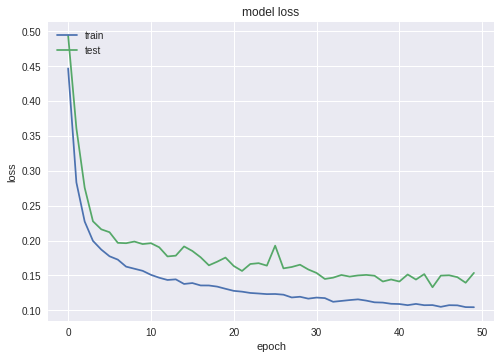

In [13]:

plt.plot(descriptor_history.history['loss'])
plt.plot(descriptor_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
from keras.models import load_model
from get_data import get_data
%cd hpatches-benchmark
!git pull 
%cd ..
!mkdir -p results

generate_desc_csv(descriptor_model, seqs_test, use_clean=False)

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/deepLearning/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/deepLearning/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/deepLearning/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval

/content/deepLearning/hpatches-benchmark
Already up to date.
/content/deepLearning


100%|██████████| 40/40 [07:34<00:00,  7.69s/it]



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:36<00:00, 10324.64it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:36<00:00, 10384.30it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:36<00:00, 10340.19it/s]
>> Verification task finished in 298 secs  
Verification task results:
Mean Average Precision is 0.792403

>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100% 40/40 [02:09<00:00,  4.38s/it]
>> Matching task finished in 130 secs  
Matching task results:
Mean Average Precision is 0.184733



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
tcmalloc: large alloc